C:\Users\dhars\AppData\Local\Temp\ipykernel_9744\3798695847.py:38: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(ca_holidays).astype(int)


Train date range: 2019-07-22 to 2024-07-01
Validation date range: 2024-07-02 to 2024-09-29

Training model for Local Route...

Training model for Light Rail...

Training model for Light Rail...

Training model for Peak Service...

Training model for Peak Service...

Training model for Rapid Route...

Training model for Rapid Route...

Training model for School...

Training model for School...

All models trained successfully!

=== Model Performance (RMSE on 90-Day Validation Set) ===
Local Route: 3,993.85
Light Rail: 2,591.92
Peak Service: 83.02
Rapid Route: 4,909.03
School: 1,024.25

All models trained successfully!

=== Model Performance (RMSE on 90-Day Validation Set) ===
Local Route: 3,993.85
Light Rail: 2,591.92
Peak Service: 83.02
Rapid Route: 4,909.03
School: 1,024.25


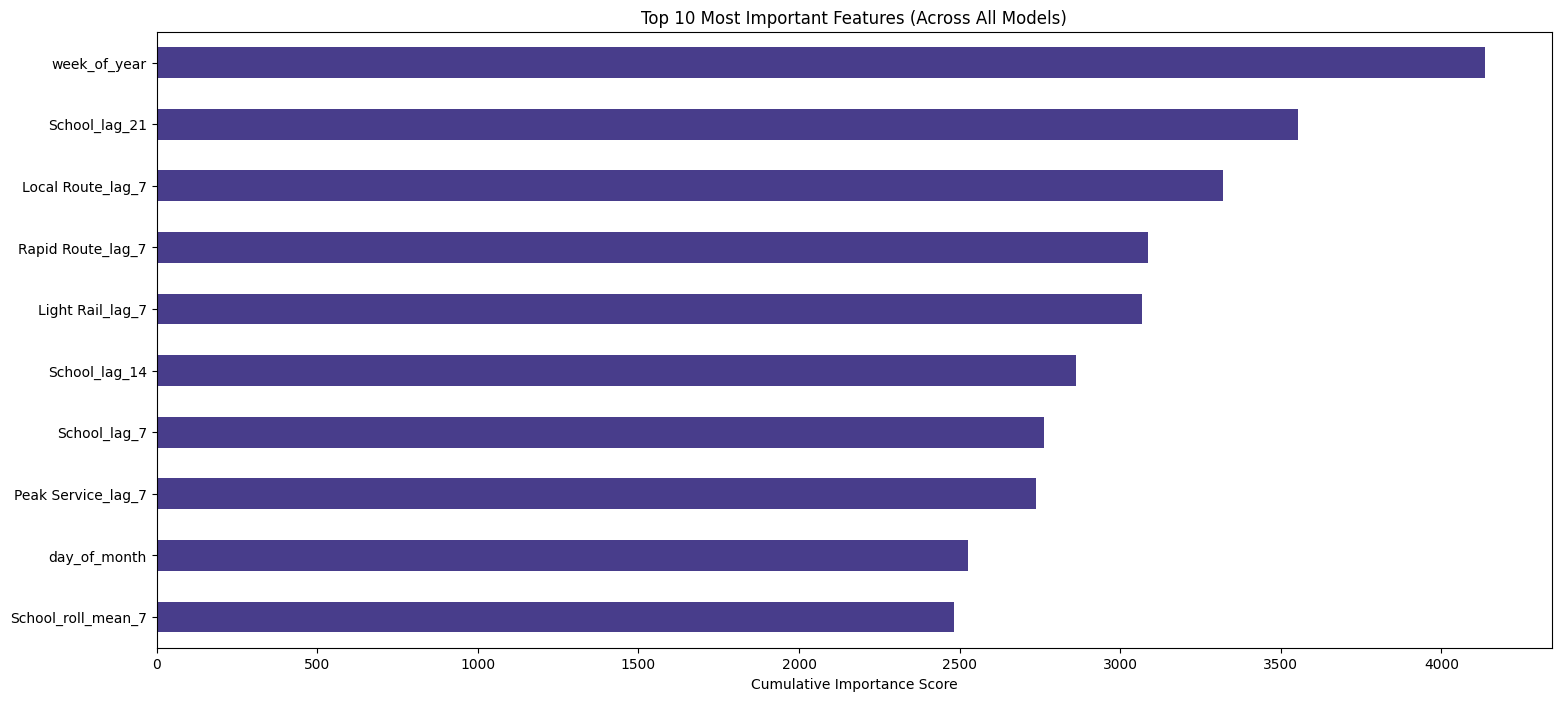

C:\Users\dhars\AppData\Local\Temp\ipykernel_9744\3798695847.py:38: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(ca_holidays).astype(int)



=== Raw Forecast Output (System Format) ===
| Date                | Local Route   | Light Rail   | Peak Service   | Rapid Route   | School   |
|:--------------------|:--------------|:-------------|:---------------|:--------------|:---------|
| 2024-09-30 00:00:00 | 7004          | 4421         | 187            | 9827          | 1006     |
| 2024-10-01 00:00:00 | 7004          | 3699         | 190            | 9682          | 1485     |
| 2024-10-02 00:00:00 | 5133          | 3385         | 119            | 8210          | 1548     |
| 2024-10-03 00:00:00 | 6301          | 3439         | 121            | 8649          | 966      |
| 2024-10-04 00:00:00 | 4263          | 1895         | 69             | 3918          | 273      |
| 2024-10-05 00:00:00 | 1698          | 1909         | 24             | 3298          | 60       |
| 2024-10-06 00:00:00 | 1188          | 1897         | 24             | 3259          | 47       |

=== Structured Forecast (Report Format) ===
| Service Type   | 

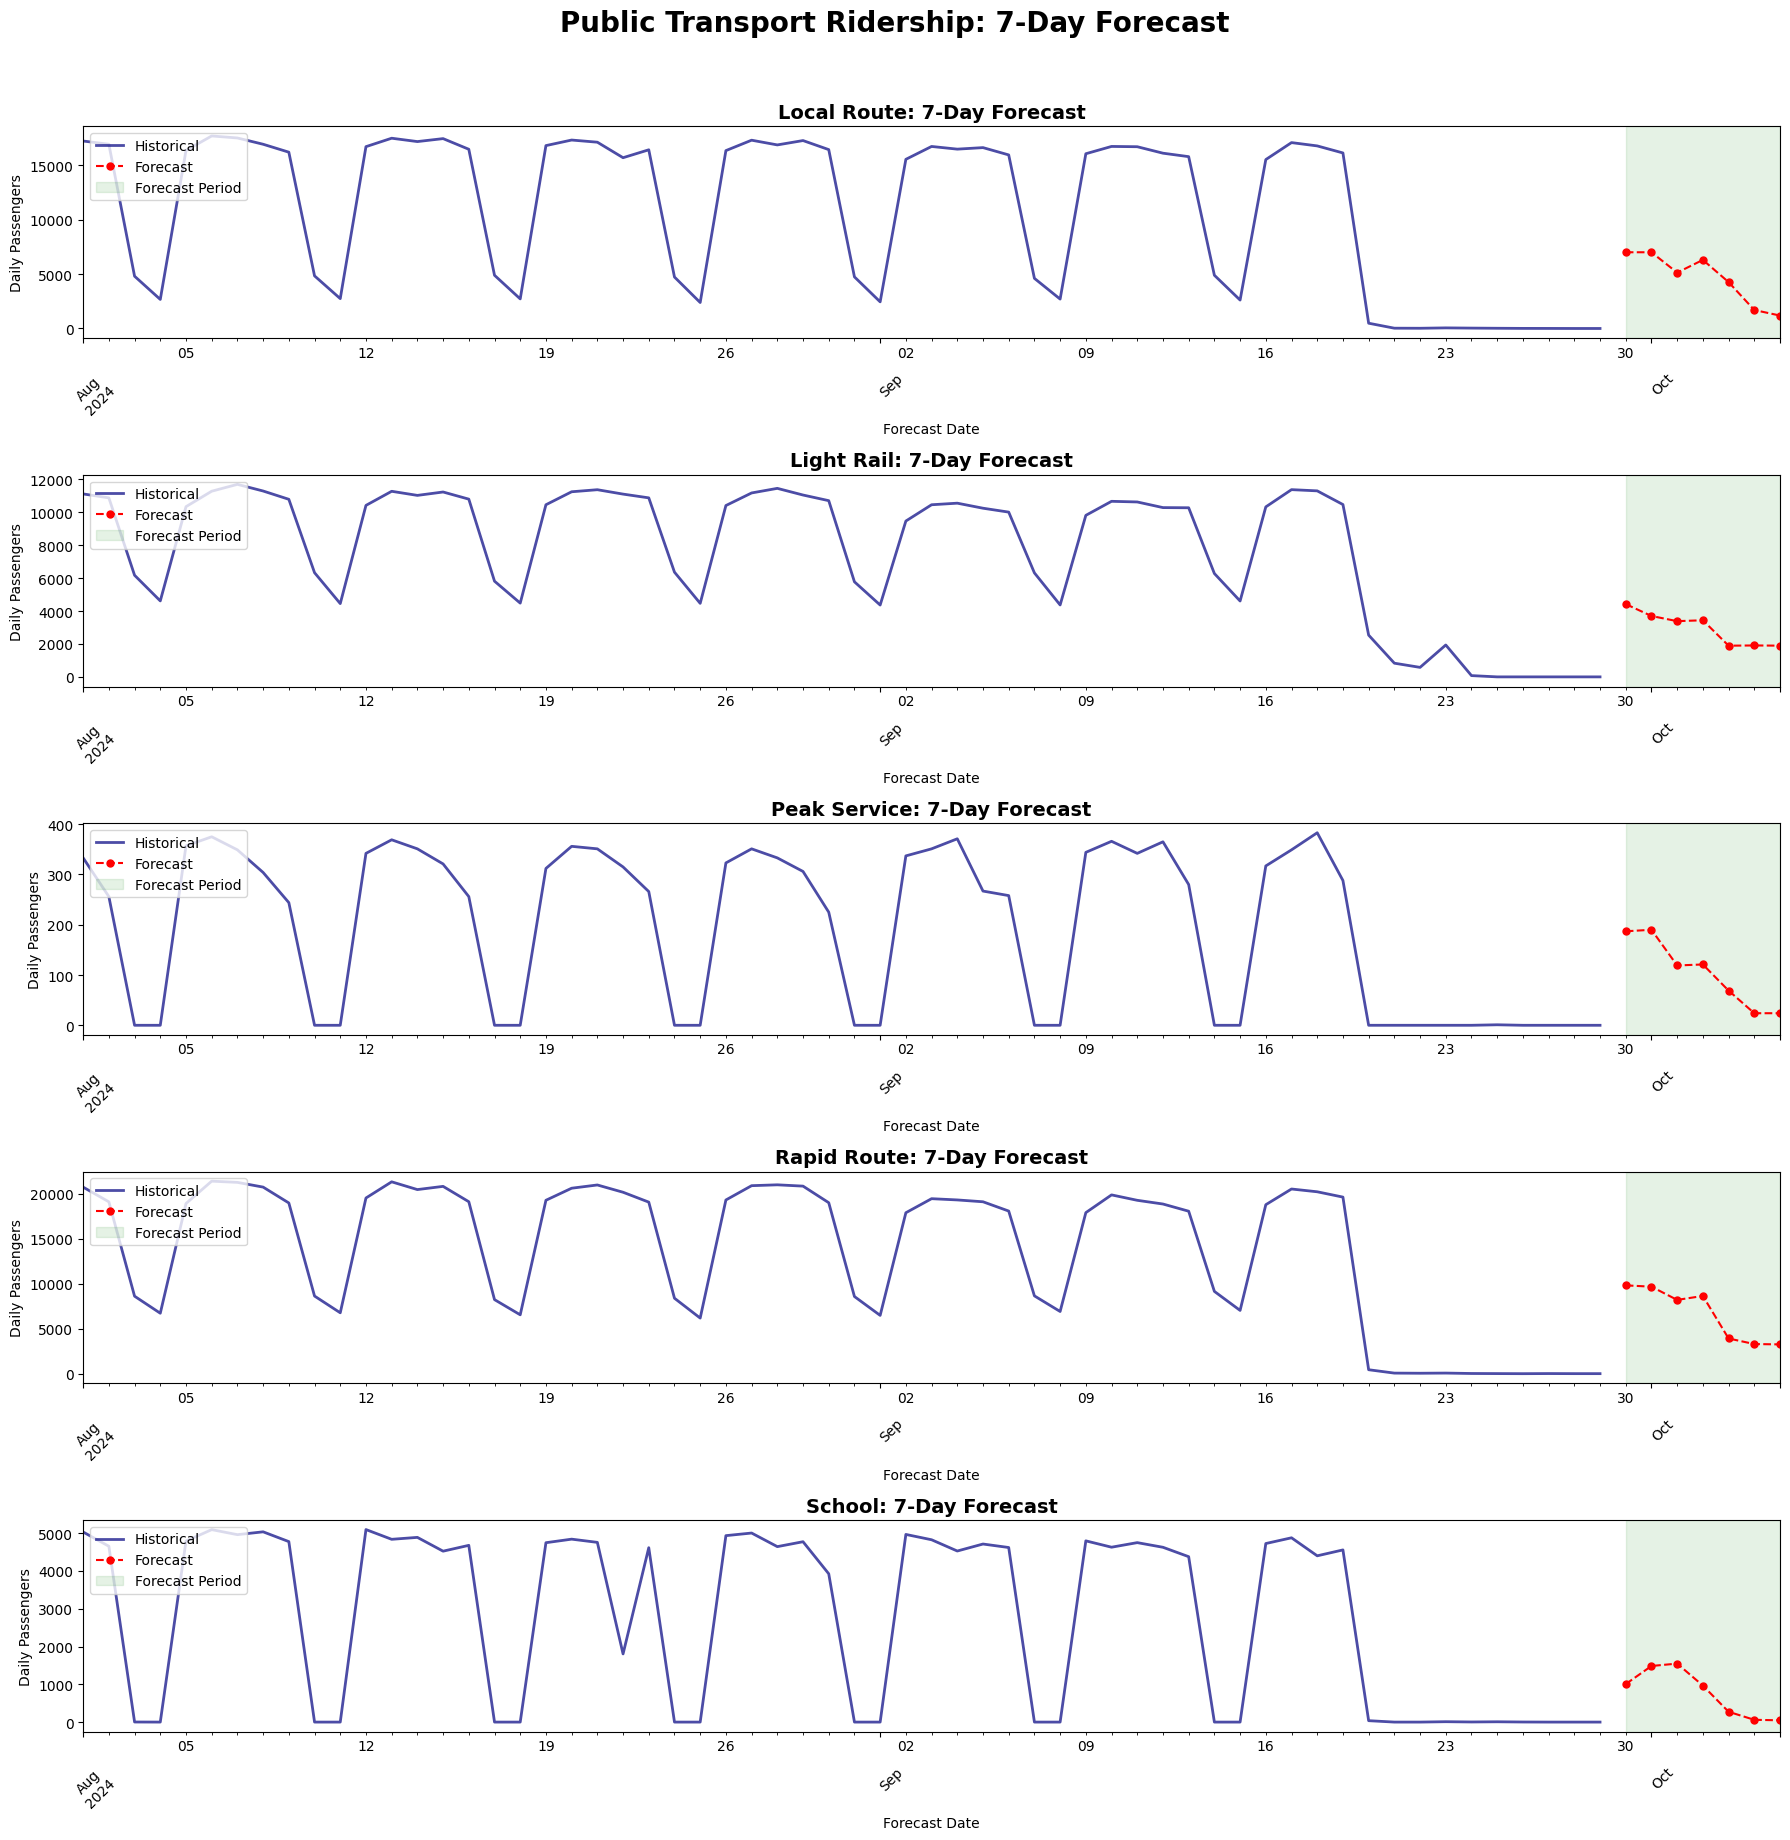


Forecast generation complete! The model has produced 7-day predictions for all service types.


In [3]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import holidays
from tabulate import tabulate # For professional markdown tables
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cell 2: Load and Prepare Data
FILE_PATH = '../data/Daily_Public_Transport_Passenger_Journeys.xlsx'
df = pd.read_excel(FILE_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
df = df.dropna(how='all').fillna(0)

# Define core target columns (as per project brief)
TARGET_COLS = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
df = df[TARGET_COLS] # Filter only the required columns

# Cell 3: Feature Engineering Function (Focus on Time and Lags)
def create_features(df):
    """Create robust time series and lag features."""
    df = df.copy()
    
    # Time-based features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['week_of_year'] = df.index.isocalendar().week.astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Holiday features
    ca_holidays = holidays.Canada(years=range(2019, 2026))
    df['is_holiday'] = df.index.isin(ca_holidays).astype(int)
    
    # School holiday feature
    df['is_school_holiday'] = df.index.to_series().apply(lambda date: 
        1 if (date.month in [7, 8] or  # Summer break
             (date.month == 12 and date.day >= 20) or  # Winter break start
             (date.month == 1 and date.day <= 5))  # Winter break end
        else 0
    )
    
    # Combined binary feature: is it a non-holiday weekday?
    df['is_school_day'] = ((df['is_weekend'] == 0) & 
                          (df['is_holiday'] == 0) & 
                          (df['is_school_holiday'] == 0)).astype(int)
    
    # Lag features (Crucial for weekly seasonality)
    for col in TARGET_COLS:
        for lag in [7, 14, 21]: # Weekly, Bi-weekly, Tri-weekly lags
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        
        # Rolling means (Trend Smoothing)
        df[f'{col}_roll_mean_7'] = df[col].shift(7).rolling(window=7).mean()
        
    return df

# Cell 4: Create Features and Split Data
df_features = create_features(df)
df_features = df_features.dropna() 

# Define features (X) and targets (y)
BASE_FEATURES = [
    'day_of_week', 'day_of_month', 'month', 'year', 'week_of_year',
    'is_weekend', 'is_holiday', 'is_school_holiday', 'is_school_day'
]
LAG_FEATURES = [col for col in df_features.columns if any(f'lag_' in col or 'roll_mean' in col for _ in TARGET_COLS)]
FEATURES = BASE_FEATURES + LAG_FEATURES

X = df_features[FEATURES]
y = df_features[TARGET_COLS]

# Time-based split: Use last 90 days for validation
split_date = df_features.index.max() - pd.Timedelta(days=90)
X_train, y_train = X.loc[X.index <= split_date], y.loc[y.index <= split_date]
X_val, y_val = X.loc[X.index > split_date], y.loc[y.index > split_date]

print(f'Train date range: {X_train.index.min().date()} to {X_train.index.max().date()}')
print(f'Validation date range: {X_val.index.min().date()} to {X_val.index.max().date()}')

# Cell 5: Train Models
models = {}
val_preds = pd.DataFrame(index=X_val.index)
feature_importances = pd.DataFrame(index=FEATURES)

lgb_params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

for col in TARGET_COLS:
    print(f"\nTraining model for {col}...")
    model = lgb.LGBMRegressor(**lgb_params)
    
    model.fit(X_train, y_train[col],
              eval_set=[(X_val, y_val[col])],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    models[col] = model
    val_preds[col] = model.predict(X_val)
    feature_importances[col] = model.feature_importances_

print("\nAll models trained successfully!")

# Cell 6: Model Evaluation
rmses = {}
print("\n=== Model Performance (RMSE on 90-Day Validation Set) ===")
for col in TARGET_COLS:
    rmse = np.sqrt(mean_squared_error(y_val[col], val_preds[col]))
    rmses[col] = rmse
    print(f'{col}: {rmse:,.2f}')

# Feature Importance Visualization
plt.figure(figsize=(18, 8))
feature_importances.sum(axis=1).sort_values(ascending=False).head(10).plot(
    kind='barh', 
    title='Top 10 Most Important Features (Across All Models)',
    color='darkslateblue'
)
plt.gca().invert_yaxis()
plt.xlabel('Cumulative Importance Score')
plt.show()

# Cell 7: Generate Forecast
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

# Create future features
future_df = pd.DataFrame(index=future_dates)
combined_df = pd.concat([df[TARGET_COLS], future_df])
combined_features = create_features(combined_df)
X_future = combined_features[FEATURES].loc[future_dates]

# Generate forecast
forecast = pd.DataFrame(index=future_dates)
forecast.index.name = 'Date'

for col in TARGET_COLS:
    forecast[col] = models[col].predict(X_future)

# Ensure predictions are non-negative and round to integers
forecast[forecast < 0] = 0
forecast = forecast.round(0).astype(int)

# Display forecasts
print("\n=== Raw Forecast Output (System Format) ===")
print(tabulate(forecast, headers='keys', tablefmt='pipe', showindex=True, numalign="left"))

print("\n=== Structured Forecast (Report Format) ===")
forecast_structured = forecast.T
forecast_structured.columns.name = 'Forecast Date'
forecast_structured.index.name = 'Service Type'
print(tabulate(forecast_structured, headers='keys', tablefmt='pipe', showindex=True, numalign="left"))

# Cell 8: Visualization
fig, axes = plt.subplots(len(TARGET_COLS), 1, figsize=(18, 18), sharex=False)
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(TARGET_COLS):
    # Plot last 60 days of history + forecast
    df[col].iloc[-60:].plot(ax=axes[i], label='Historical', color='navy', linewidth=2, alpha=0.7)
    forecast[col].plot(ax=axes[i], label='Forecast', color='red', linestyle='--', marker='o', markersize=5)
    
    # Highlight forecast period
    axes[i].axvspan(forecast.index.min(), forecast.index.max(), color='green', alpha=0.1, label='Forecast Period')
    
    axes[i].set_title(f'{col}: 7-Day Forecast', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Daily Passengers')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(loc='upper left', fontsize=10)

plt.suptitle('Public Transport Ridership: 7-Day Forecast', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nForecast generation complete! The model has produced 7-day predictions for all service types.")